In [1]:
import torch
import torchvision
from torch import nn
from transformers import AutoTokenizer, CLIPModel, CLIPVisionModelWithProjection
from train_c_lora import WurstCore
from train_b import WurstCore as WurstCoreB
from warp_core.utils import load_or_fail
import yaml
import matplotlib.pyplot as plt
from PIL import Image
import requests

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
# SETUP WARPCORE
config_file = 'configs/finetune_c_3b_lora.yml'
with open(config_file, "r", encoding="utf-8") as file:
    loaded_config = yaml.safe_load(file)
    loaded_config['use_fsdp'] = False
    loaded_config['batch_size'] = 1

warpcore = WurstCore(
    config_dict=loaded_config,
    device=device
)

# STAGE B
config_file_b = 'configs/finetune_b_3b.yml'
with open(config_file_b, "r", encoding="utf-8") as file:
    config_file_b = yaml.safe_load(file)
    config_file_b['use_fsdp'] = False
    config_file_b['batch_size'] = 1
    
warpcore_b = WurstCoreB(
    config_dict=config_file_b,
    device=device
)

>>> RESUMING TRAINING FROM ITER  700


In [15]:
# SETUP MODELS & DATA
extras = warpcore.setup_extras_pre()
data = warpcore.setup_data(extras)
models = warpcore.setup_models(extras)
models.generator.bfloat16().eval().requires_grad_(False)
print("CONTROLNET READY")

# extras_b = warpcore_b.setup_extras_pre()
# models_b = warpcore_b.setup_models(extras_b)
# models_b.generator.bfloat16().eval().requires_grad_(False)
# print("STAGE B READY")
# pass

Training with batch size 1 (1/GPU)


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModelWithProjection: ['text_model.encoder.layers.8.mlp.fc2.bias', 'text_model.final_layer_norm.weight', 'text_model.encoder.layers.11.mlp.fc1.bias', 'text_model.encoder.layers.8.layer_norm1.weight', 'text_model.encoder.layers.4.self_attn.out_proj.bias', 'text_model.encoder.layers.10.self_attn.q_proj.bias', 'text_model.encoder.layers.3.self_attn.out_proj.weight', 'text_model.encoder.layers.1.layer_norm1.bias', 'text_model.encoder.layers.11.self_attn.v_proj.bias', 'text_model.encoder.layers.2.self_attn.q_proj.bias', 'text_model.encoder.layers.5.mlp.fc2.bias', 'text_model.encoder.layers.5.layer_norm2.bias', 'text_model.encoder.layers.6.layer_norm1.bias', 'text_model.encoder.layers.11.layer_norm1.weight', 'text_model.encoder.layers.7.self_attn.k_proj.bias', 'text_model.encoder.layers.0.layer_norm2.weight', 'text_model.encoder.layers.0.self_attn.v_proj.weight', 'text_model.encoder

/admin/home-warp/warp_env/lib/python3.8/site-packages/torch/nn/modules/module.py:844: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if param.grad is not None:


Updating tokens: [(34928, 'snails'), (23132, 'snail')]
LoRA training 128 layers
CONTROLNET READY


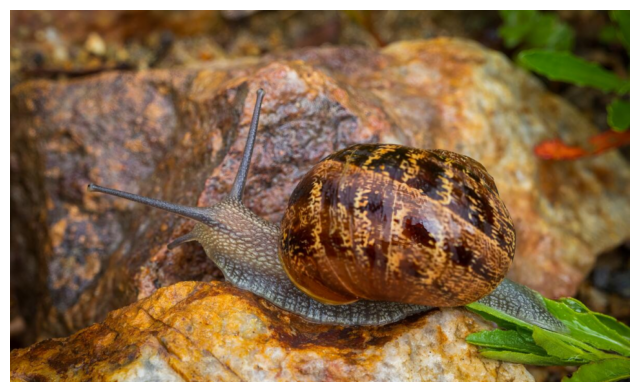

['photo of a snail climbing some rocks']


In [16]:
# PREVIEW BATCH
batch = next(data.iterator)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in batch['images'].clamp(0, 1)], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

print(batch['captions'])

In [32]:
# models.lora.embeddings
# models.lora.embeddings.embeddings.shape

# models.lora.weights[0].lora_down
models.lora.weights[0].lora_up

Parameter containing:
tensor([[ 1.5938, -0.0312, -1.1094,  ..., -0.2656,  0.3555,  0.7461],
        [-0.3203, -0.2637,  0.4805,  ...,  0.0869, -0.6953,  1.2188],
        [-0.5117,  0.3418, -0.3926,  ..., -0.0601,  0.5117,  0.9453],
        ...,
        [-1.7031, -0.3438,  0.6719,  ...,  1.3359, -0.2432, -0.5859],
        [-2.3906,  0.2295,  0.7109,  ..., -0.3457,  1.5078, -1.2188],
        [ 0.0309, -0.4453, -0.2432,  ..., -0.6836, -0.1523,  0.3281]],
       device='cuda:0', dtype=torch.bfloat16)

In [29]:
# models.clip_text_model.embeddings.token_embedding.parametrizations.weight[0].embeddings

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)

In [34]:
# checkpoint = load_or_fail('/weka/home-warp/models/v3_release/stage_c_3b_lora/lora_1k.safetensors')
# checkpoint